# 6D tracking in MAD-X
**G. Sterbini, CERN, BE-ABP-INC**

## The CAS-22 

We will study a CERN Advanced (proton) Synchrotron with a flat bottom momentum of 2.2 GeV/c and a top momentup up to 22 GeV/c (let's call it **CAS-22**). 

We will use *cpymad* python package (https://github.com/hibtc/cpymad). To install it you can follow the instructions [here](https://github.com/cerncas/2022Sevrier/blob/main/student_instructions.md).

Try to execute and to study step-by-step this notebook.

In [1]:
# as usual we will use MAD-X via python
from cpymad.madx import Madx

# standard packages and modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# standard configurations
get_ipython().run_line_magic('matplotlib', 'inline')
%config InlineBackend.figure_format = 'retina' # retina display

# This functions will be used for the printing/plotting (nothing fundamental)
def showTunes():
    print(f'Q1 = {madx.table.summ.q1[0]:1.6}')
    print(f'Q2 = {madx.table.summ.q2[0]:1.6}')
    
def showChroma():
    print(f'DQ1 = {madx.table.summ.dq1[0]:1.6}')
    print(f'DQ2 = {madx.table.summ.dq2[0]:1.6}')

def plotLatticeSeries(ax, series, height=1., v_offset=0., color='r',alpha=0.5,lw=1):
    aux=series
    ax.add_patch(
    patches.Rectangle(
        (aux.s-aux.l, v_offset-height/2.),   # (x,y)
        aux.l,          # width
        height,          # height
        color=color, alpha=alpha,lw=lw
    )
    )
    return;

def BeamParameters(pc_GeV, en_x_m=5e-6, en_y_m=5e-6, deltap_p=1e-3, verbose=True):
    from scipy.constants import speed_of_light
    import scipy.constants as sco
    
    # Tm, beam rigidity
    Brho_Tm=1e9/speed_of_light*pc_GeV
    # GeV, rest mass energy
    E_0_GeV=sco.physical_constants['proton mass energy equivalent in MeV'][0]/1000 
    E_tot_GeV=np.sqrt(pc_GeV**2+E_0_GeV**2)
    E_kin_GeV=E_tot_GeV-E_0_GeV
    gamma_r=E_tot_GeV/E_0_GeV
    beta_r=pc_GeV/E_tot_GeV
    eg_x_m=en_x_m/gamma_r/beta_r
    eg_y_m=en_y_m/gamma_r/beta_r


    if verbose:
        print(f'''Particle type: proton
        Beam momentum= {pc_GeV:2.3f} GeV/c
        normalized x-emittance= {en_x_m*1e6:2.3f} mm mrad
        normalized y-emittance= {en_y_m*1e6:2.3f} mm mrad
        deltap/p= {deltap_p} 
        -> Beam total energy= {E_tot_GeV:2.3f} GeV
        -> Beam kinetic energy= {E_kin_GeV:2.3f} GeV
        -> Beam rigidity= {Brho_Tm:2.3f} Tm
        -> relativistic beta= {beta_r:2.5f}
        -> relativistic gamma= {gamma_r:2.3f}
        -> geometrical x-emittance= {eg_x_m*1e6:2.3f} mm mrad
        -> geometrical y-emittance= {eg_y_m*1e6:2.3f} mm mrad
        ''')
    return {'pc_GeV': pc_GeV,'Brho_Tm': Brho_Tm,'E_0_GeV': E_0_GeV, 'E_tot_GeV':E_tot_GeV,
            'E_kin_GeV': E_kin_GeV, 'gamma_r': gamma_r, 'beta_r':beta_r, 'en_x_m':en_x_m, 'en_y_m':en_y_m,
            'eg_x_m':eg_x_m, 'eg_y_m':eg_y_m, 'deltap_p':deltap_p}

print('====== Injection Energy ======')
beamFB=BeamParameters(2.2, en_x_m=5e-6, en_y_m=5e-6, deltap_p=2e-3)

print('======== Top Energy ========')
beamFT=BeamParameters(22, en_x_m=5e-6, en_y_m=5e-6, deltap_p=2e-4)

====== Injection Energy ======
Particle type: proton
        Beam momentum= 2.200 GeV/c
        normalized x-emittance= 5.000 mm mrad
        normalized y-emittance= 5.000 mm mrad
        deltap/p= 0.002 
        -> Beam total energy= 2.392 GeV
        -> Beam kinetic energy= 1.453 GeV
        -> Beam rigidity= 7.338 Tm
        -> relativistic beta= 0.91984
        -> relativistic gamma= 2.549
        -> geometrical x-emittance= 2.132 mm mrad
        -> geometrical y-emittance= 2.132 mm mrad
        
======== Top Energy ========
Particle type: proton
        Beam momentum= 22.000 GeV/c
        normalized x-emittance= 5.000 mm mrad
        normalized y-emittance= 5.000 mm mrad
        deltap/p= 0.0002 
        -> Beam total energy= 22.020 GeV
        -> Beam kinetic energy= 21.082 GeV
        -> Beam rigidity= 73.384 Tm
        -> relativistic beta= 0.99909
        -> relativistic gamma= 23.469
        -> geometrical x-emittance= 0.213 mm mrad
        -> geometrical y-emittance= 0.213 m

In [2]:
circum_m=500. # m, machine circumference
ncell=25.
l_quad_m=.5 # m
l_dip_m=3.5 # m
lcell_m=circum_m/ncell; # m

f_m=lcell_m/(2*np.sqrt(2)) # This will give pi/2 phase advance in thin lens approximation (no dipoles)

nQuadrupoles=2*ncell
nDipoles=4*ncell # four dipoles per cell
angleOfDipole_rad=2*np.pi/nDipoles 
fieldOfDipole_T= angleOfDipole_rad*beamFT['Brho_Tm']/l_dip_m
gradientOfQuadrupole_T_m= 1/f_m*beamFT['Brho_Tm']/l_quad_m
r_quadrupole_m= 0.065;
v_gap_dipole_m= 0.065;
h_gap_dipole_m= 0.09;


print(f'''Machine circumference: {circum_m} m
Number of FODO cells= {ncell}
Quadrupole length= {l_quad_m} m
Dipole length= {l_dip_m} m
Number of quadrupoles= {nQuadrupoles}
Number of dipoles= {nDipoles}
Quadrupole focal length= {f_m:2.3f} m
Radius of the quadrupole's aperture =  {r_quadrupole_m*1000} mm
Horizontal half-gap of the dipoles=  {h_gap_dipole_m*1000} mm
Vertical half-gap of the dipoles=  {v_gap_dipole_m*1000} mm

-> Length of FODO= {lcell_m} m
-> Angle of dipole = {angleOfDipole_rad*1000: 2.3f} mrad
-> Field of dipole = {fieldOfDipole_T: 2.3f} T
-> K1 of quadrupole = {1/f_m/l_quad_m: 2.3f} 1/m^2
-> Gradient of quadrupole = {gradientOfQuadrupole_T_m: 2.3f} T/m
-> Field on the tip of the quadrupole = {gradientOfQuadrupole_T_m*r_quadrupole_m: 2.3f} T
''')

Machine circumference: 500.0 m
Number of FODO cells= 25.0
Quadrupole length= 0.5 m
Dipole length= 3.5 m
Number of quadrupoles= 50.0
Number of dipoles= 100.0
Quadrupole focal length= 7.071 m
Radius of the quadrupole's aperture =  65.0 mm
Horizontal half-gap of the dipoles=  90.0 mm
Vertical half-gap of the dipoles=  65.0 mm

-> Length of FODO= 20.0 m
-> Angle of dipole =  62.832 mrad
-> Field of dipole =  1.317 T
-> K1 of quadrupole =  0.283 1/m^2
-> Gradient of quadrupole =  20.756 T/m
-> Field on the tip of the quadrupole =  1.349 T



In [3]:
madx = Madx()


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.08.01  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2022.02.25               +
  + Execution date: 2022.11.15 14:54:28      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [4]:
madx = Madx(stdout=True)
madx.input(f'''
circum={circum_m};
ncell ={ncell}; !Number of cells 
lcell = {lcell_m};
lq = {l_quad_m}; !Length of a quadrupole
ldip = {l_dip_m};
!element definitions;
!define bending magnet as multipole 
!we have 4 bending magnets per cell
!mb:multipole,knl={{2.0*pi/(4*ncell)}};

mb: sbend, l=ldip, angle=2.0*pi/(4*ncell), apertype=ellipse, aperture= {{{h_gap_dipole_m}, {v_gap_dipole_m}}};

f={f_m};

!define quadrupoles as multipoles 
qf: multipole,knl:={{0,1/f+qtrim_f}}; 
qd: multipole,knl:={{0,-1/f+qtrim_d}};
qf: quadrupole, l=lq, K1:=1/f/lq  + qtrim_f/lq, apertype=ellipse, aperture= {{{r_quadrupole_m}, {r_quadrupole_m}}}; 
qd: quadrupole, l=lq, K1:=-1/f/lq + qtrim_d/lq, apertype=ellipse, aperture= {{{r_quadrupole_m}, {r_quadrupole_m}}};

!define the sextupoles as multipole
lsex = 0.00001; ! dummy length, only used in the sequence;

!ATTENTION: must use knl:= and NOT knl= to match later! 
msf: multipole, knl:={{0,0,ksf}};
msd: multipole, knl:={{0,0,ksd}};

!sequence declaration;
!I switch off the warning to limit the output
!use this option with moderation (I switch it back in after the sequence)
option, warn=false;
cas22: sequence, refer=centre, l=circum;
   start_machine: marker, at = 0;
   n = 1;
   while (n < ncell+1) {{
    qf: qf,   at=(n-1)*lcell+ lq/2.0;
    msf: msf, at=(n-1)*lcell + lsex/2.0+lq/1.0;
    mb: mb,   at=(n-1)*lcell + 0.15*lcell;
    mb: mb,   at=(n-1)*lcell + 0.35*lcell;
    qd: qd,   at=(n-1)*lcell + 0.50*lcell+ lq/2.0;
    msd: msd, at=(n-1)*lcell + 0.50*lcell + lsex/2.0+lq/1.0;
    mb: mb,   at=(n-1)*lcell + 0.65*lcell;
    mb: mb,   at=(n-1)*lcell + 0.85*lcell;
    n = n + 1;
}}
end_machine: marker at=circum;
endsequence;
option, warn=true;

!define the beam and its properties
beam, particle = proton, sequence=cas22, energy = {beamFB['E_tot_GeV']}, exn={beamFB['en_x_m']}, eyn={beamFB['en_y_m']},sige={beamFB['en_y_m']};

use, sequence=cas22;
select, flag=twiss, column=apertype, aper_1, aper_2;

ksf=0;
ksd=0;
twiss;
''')
myTwiss=madx.table.twiss.dframe()
showTunes()


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.08.01  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2022.02.25               +
  + Execution date: 2022.11.15 14:54:28      +
  ++++++++++++++++++++++++++++++++++++++++++++
++++++ info: element redefined: qf
++++++ info: element redefined: qd
enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
               500                 -0      0.02956213714        5.816102963 

                q1                dq1            betxmax              dxmax 
       6.261774209       -7.905974753         32.6904272        3.608534248 

             dxrms             xcomax             xcorms                 q2 
       2.749437494                  0                  0        6

**Comments**: in thin lens approximations and neglecting the weak focusing of the dipoles we expected Q1 = 6.25 and Q2 = 6.25.

In [5]:
# option to see the value of the optics functions also inside the elements
madx.input('''
select,flag=interpolate, class=drift, slice=4, range=#s/#e;
select,flag=interpolate, class=quadrupole, slice=8, range=#s/#e;
select,flag=interpolate, class=sbend, slice=10, range=#s/#e;
twiss;
'''
)
myTwissHR=madx.table.twiss.dframe() # HR stands for High Resolution in the s-direction
twissBeforeQCorrection=myTwissHR
summBeforeQCorrection=madx.table.summ

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
               500                 -0      0.02956213714        5.816102963 

                q1                dq1            betxmax              dxmax 
       6.261774209       -7.905974753        33.27233422        3.639850808 

             dxrms             xcomax             xcorms                 q2 
       2.701910608                  0                  0        6.117140658 

               dq2            betymax              dymax              dyrms 
      -8.013290877        33.72534709                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

## CAS-22 lattice

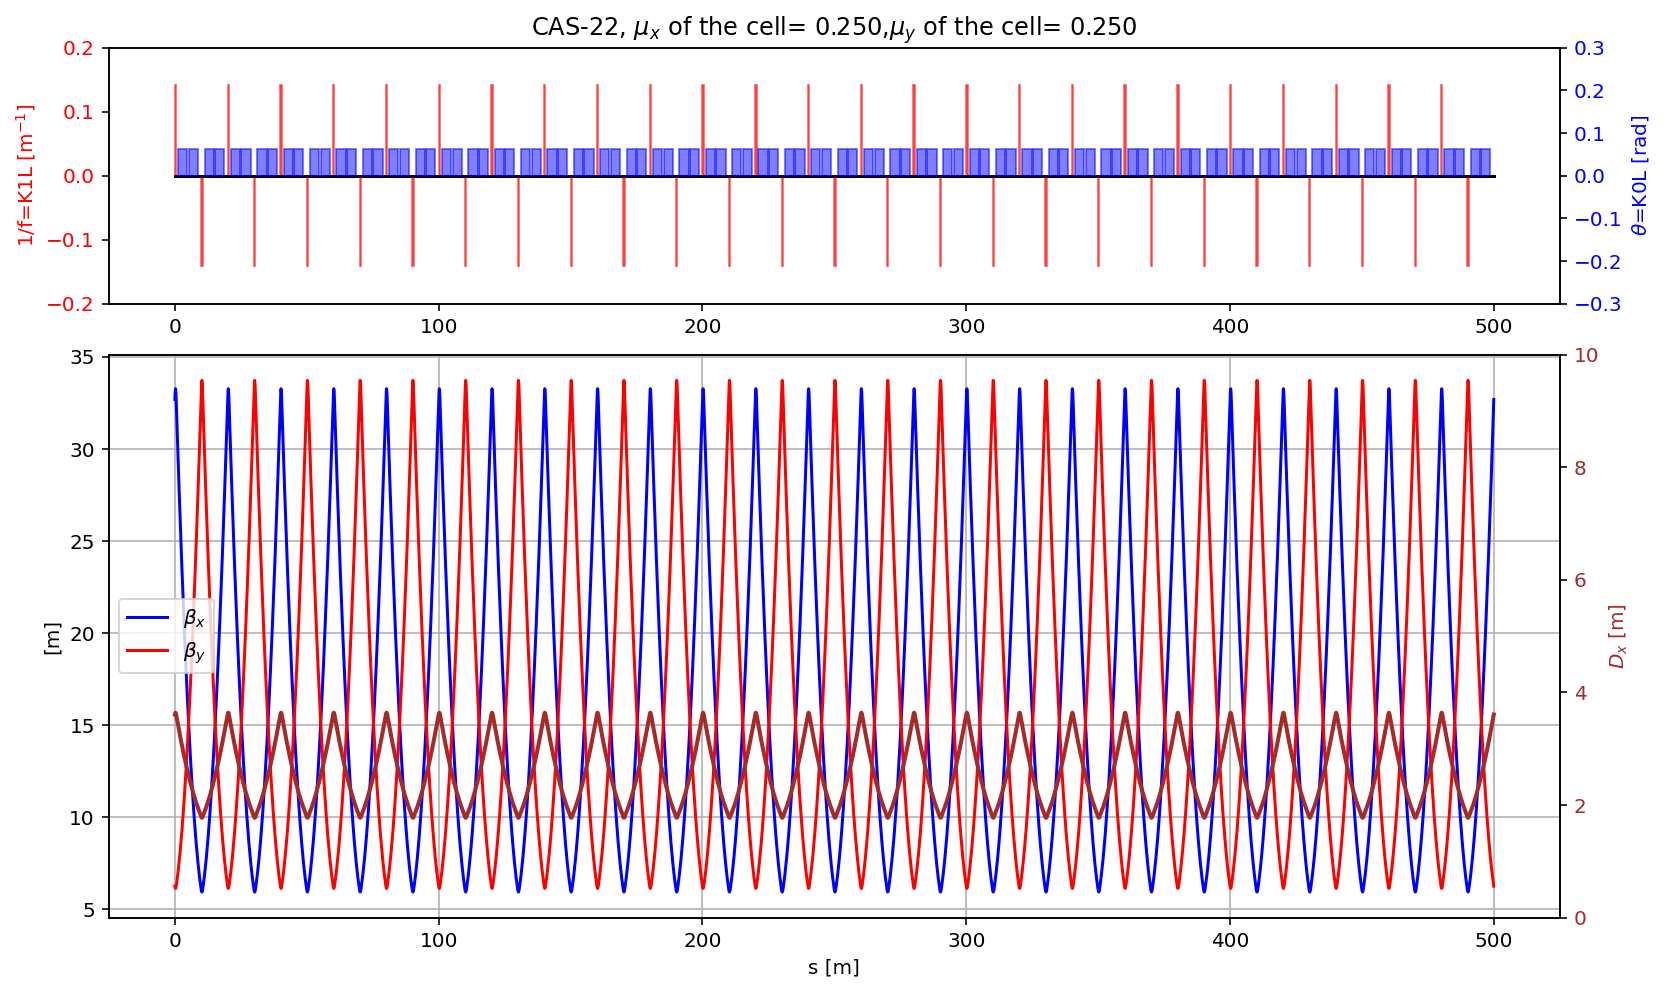

In [6]:
# just plotting
fig = plt.figure(figsize=(13,8))
ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
plt.plot(myTwiss['s'],0*myTwiss['s'],'k')

DF=myTwiss[(myTwiss['keyword']=='quadrupole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')
    
DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')

    color = 'red'
ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim(-.2,.2)
plt.title(f'CAS-22, $\\mu_x$ of the cell={madx.table.summ.Q1[0]/ncell: 2.3f},\
$\\mu_y$ of the cell={madx.table.summ.Q1[0]/ncell: 2.3f}')
ax2 = ax1.twinx()

color = 'blue'
ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)
ax2.tick_params(axis='y', labelcolor=color)

DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k2l, v_offset=aux.k2l/2, color='y')

DF=myTwiss[(myTwiss['keyword']=='sbend')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.angle, v_offset=aux.angle/2, color='b')

    
plt.ylim(-.3,.3)

axbeta=plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

plt.plot(myTwissHR['s'],myTwissHR['betx'],'b', label='$\\beta_x$')
plt.plot(myTwissHR['s'],myTwissHR['bety'],'r', label='$\\beta_y$')
plt.legend(loc='best')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.grid()

ax3 = plt.gca().twinx() 
plt.plot(myTwissHR['s'],myTwissHR['dx'],'brown', label='$D_x$', lw=2)
ax3.set_ylabel('$D_x$ [m]', color='brown')
ax3.tick_params(axis='y', labelcolor='brown')
plt.ylim(0, 10);

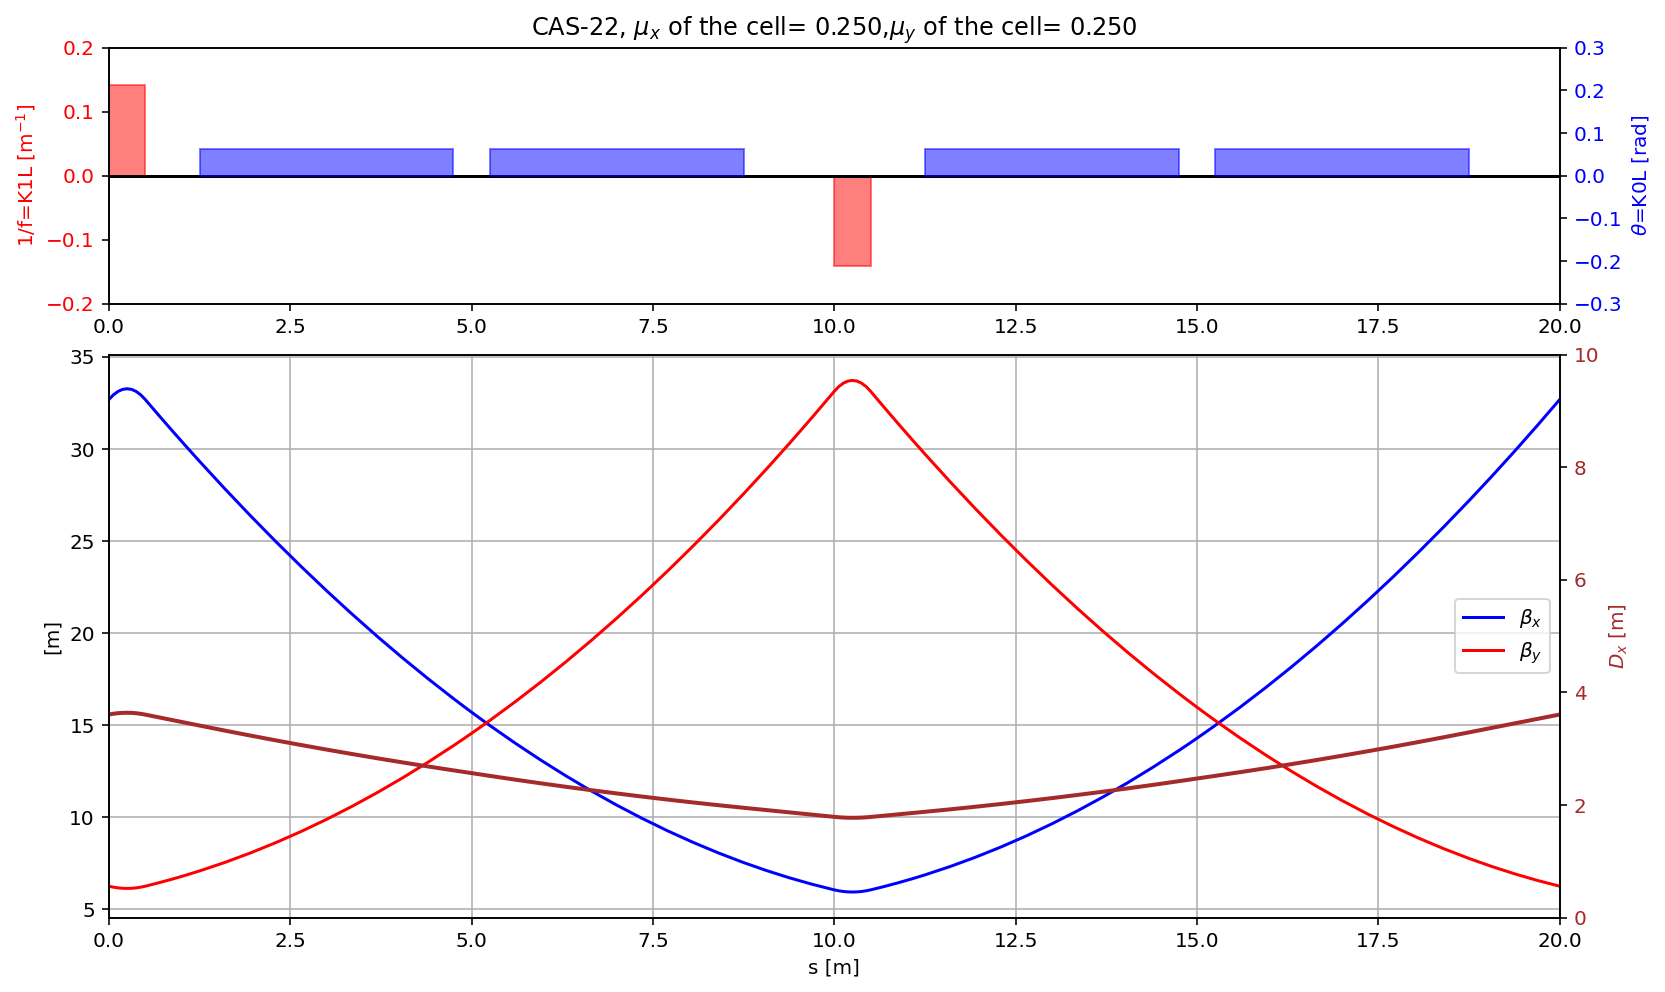

In [7]:
fig.gca().set_xlim(0, lcell_m)
display(fig)

**Comments**: we expected a $\beta_{max}$ of about twice the FODO cell ( $\beta_{max}\approx 40$ m).

### Can you determing by a numerical experiment (tracking) the machine tune?

In [8]:
# I use a very high number of slices such to have the thin machine as close as possible
# to the thick one
madx.input('''
select, flag=makethin, class=quadrupole, slice=8;
select, flag=makethin, class=sbend, slice=10;
makethin, sequence=cas22;
use, sequence=cas22;
twiss;
''');
showTunes()

makethin: slicing sequence : cas22
enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
               500                 -0      0.02956208299        5.816108291 

                q1                dq1            betxmax              dxmax 
       6.261777289       -8.444895184        33.26312423        3.639438892 

             dxrms             xcomax             xcorms                 q2 
       2.673316444                  0                  0        6.117125779 

               dq2            betymax              dymax              dyrms 
      -8.366582663        33.71578274                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                 

Please note that the **makethin** changed (slightly) the tunes (therefore) the optics. We will repeat the matching to go back to the target working point.

In [9]:
q1_target = 6.26
q2_target = 6.11
madx.input(f'''
! Matching
match, sequence=cas22;
  vary,name=qtrim_f, step=0.00001;
  vary,name=qtrim_d, step=0.00001;
  global,Q1={q1_target};
  global,Q2={q2_target};
  lmdif, calls=10, tolerance=1.0e-21;
endmatch;

!execute the TWISS command 
twiss;
''');
showTunes()

START MATCHING

number of sequences: 1
sequence name: cas22
number of variables:    2
user given constraints: 1
total constraints:      2

START LMDIF:

Initial Penalty Function =   0.53935476E-02


call:       4   Penalty function =   0.23013141E-09
call:       7   Penalty function =   0.52880502E-23
 ++++++++++ LMDIF ended: converged successfully
call:       7   Penalty function =   0.52880502E-23

MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------
Global constraint:         q1           4     6.26000000E+00     6.26000000E+00     2.38630424E-25
Global constraint:         q2           4     6.11000000E+00     6.11000000E+00     5.04941977E-24


Final Penalty Function =   5.28805019e-24





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
-----------------------------------------------------------------

In [10]:
madx.input('''
my_cavity: rfcavity, volt=1, harmon=2, LAG=0.0;
seqedit, sequence=cas22;
flatten;
INSTALL, ELEMENT=cavity_1, CLASS=my_cavity, AT=0;
flatten;
endedit;
use, sequence=cas22;
//twiss;
''')

++++++ info: seqedit - number of elements installed:  1
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0


True

In [11]:
#madx.twiss()
#madx.table.summ.dframe()
# We track a particle with 0.1 mm offset in the two planes
myString='''
TRACK;
START, X=0.0001, PX=0, Y=0.0001, PY=0, T=0, PT=.015;
START, X=0.0001, PX=0, Y=0.0001, PY=0, T=0, PT=.03;
START, X=0.0001, PX=0, Y=0.0001, PY=0, T=0, PT=.045;
START, X=0.0001, PX=0, Y=0.0001, PY=0, T=0, PT=.06;
START, X=0.0001, PX=0, Y=0.0001, PY=0, T=200, PT=.015;
RUN, TURNS=1023;
ENDTRACK;
'''
madx.input(myString);

enter TRACK module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

Full 6D closed orbit search.
Initial value of 6-D closed orbit from Twiss: 
orbit0   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

6D closed orbit found by subroutine trclor 
iteration:  11 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
particle #     4 lost turn    158  at pos. s =      0.00 element=cavity_1                                         aperture =RF-Bucket                                       
    X=  0.27221236014930944        Y=   9.5418176178426083E-005   T=   544.08026781045021     
particle #     3 lost turn    223  at pos. s =      0.00 element=cavity_1                                         aperture =RF-Bucket                                       
    X=  0.209700003

In [12]:
# track.obs0001.p0001 contains the tracking information
myParticle=madx.table['track.obs0001.p0005'].dframe()
myParticle.tail()

,number,turn,x,px,y,py,t,pt,s,e
#e,5.0,1019.0,0.038012,0.001023,0.000090,0.000003,339.016883,0.017268,0.0,2.391726
#e,5.0,1020.0,0.008494,-0.000104,0.000078,0.000007,340.204900,0.016814,0.0,2.391726
#e,5.0,1021.0,0.008627,0.001243,0.000066,0.000009,341.363693,0.016359,0.0,2.391726
#e,5.0,1022.0,0.039692,0.004360,0.000054,0.000011,342.490184,0.015905,0.0,2.391726
#e,5.0,1023.0,0.082770,0.007279,0.000044,0.000013,343.581919,0.015451,0.0,2.391726


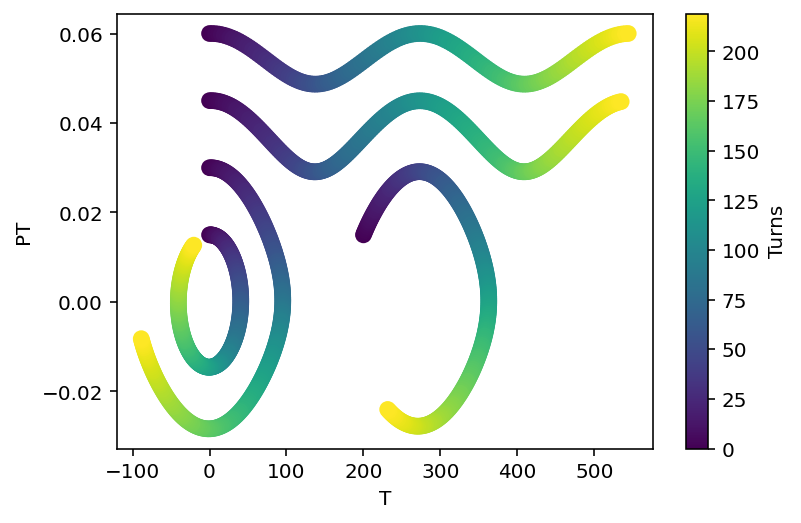

In [13]:
# I plot the first 8 turns in the x-plane
for i in range(5):
    myParticle100=madx.table[f'track.obs0001.p000{i+1}'].dframe()[0:220]
    plt.scatter(myParticle100['t'],myParticle100['pt'],c=myParticle100['turn'],s=70, edgecolor='none')
myColorbar=plt.colorbar()
myColorbar.set_label('Turns')
plt.xlabel('T')
plt.ylabel('PT');
# particle rotate clock-wise in the transverse plane

### Xtrack tracking  
From https://xsuite.readthedocs.io/en/latest/usersguide.html

`pip install xsuite `

In [14]:
import xtrack as xt
import xpart as xp
import xobjects as xo

from cpymad.madx import Madx

#########################################################################
# To import a MAD-X deferred expressions together with a MAD-X sequence #
# we proceed as follows:                                                #
#########################################################################

# Load sequence in MAD-X

# Build Xtrack line importing MAD-X expressions
line = xt.Line.from_madx_sequence(madx.sequence['cas22'],
                                  deferred_expressions=True # <--
                                  )
# Define reference particle
line.particle_ref = xp.Particles(mass0=xp.PROTON_MASS_EV, q0=1,
                                 gamma0=madx.sequence.cas22.beam.gamma)
Delta_p0c = 10e9/1*23e-6 # ramp rate 10GeV/s

energy_increase = xt.ReferenceEnergyIncrease(Delta_p0c=Delta_p0c)

line.append_element(energy_increase, 'energy_increase')

# Build tracker
tracker = xt.Tracker(line=line)


Converting sequence "cas22": 100%     
generating ./ea3d87d096dd48b1b2a831230d624738.c
the current directory is '/Users/sterbini/CERNbox/2022/CAS/Sevrier2022/examples'
running build_ext
building 'ea3d87d096dd48b1b2a831230d624738' extension
clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /Users/sterbini/test/miniconda3/include -arch x86_64 -I/Users/sterbini/test/miniconda3/include -fPIC -O2 -isystem /Users/sterbini/test/miniconda3/include -arch x86_64 -I/Users/sterbini/test/miniconda3/include/python3.9 -c ea3d87d096dd48b1b2a831230d624738.c -o ./ea3d87d096dd48b1b2a831230d624738.o -std=c99 -O3 -Wno-unused-function
clang -bundle -undefined dynamic_lookup -Wl,-rpath,/Users/sterbini/test/miniconda3/lib -L/Users/sterbini/test/miniconda3/lib -L/Users/sterbini/test/miniconda3/lib -Wl,-rpath,/Users/sterbini/test/miniconda3/lib -L/Users/sterbini/test/miniconda3/lib ./ea3d87d096dd48b1b2a831230d624738.o -o ./ea3d87d096dd48b1b2a831230d624738.c

In [15]:
madx.sequence['cas22']
n_part = 200
context = xo.ContextCpu()         # For CPU
particles = xp.Particles(_context=context,
                        p0c=madx.sequence.cas22.beam.pc*1e9,
                        x=np.random.uniform(-1e-3, 1e-3, n_part),
                        px=np.random.uniform(-3e-3, 3e-3, n_part),
                        y=np.random.uniform(-2e-3, 2e-3, n_part),
                        py=np.random.uniform(-3e-5, 3e-5, n_part),
                        zeta=np.random.uniform(-0.5e2, 0.5e2, n_part),
                        delta=np.random.uniform(-1e-4, 1e-4, n_part),
                        )

## Track (saving turn-by-turn data)
n_turns = 500
#monitor = xt.ParticlesMonitor(_context=context,
#                              start_at_turn=0, stop_at_turn=n_turns,
#                              n_repetitions=n_turns,      # <--
#                              repetition_period=1, # <--
#                              num_particles=n_part)
#for iturn in range(n_turns):
my_list_zeta = []
my_list_delta = []
my_list_x = []
my_list_px = []

#    monitor.track(particles)
for ii in range(n_turns):
    line.elements[1].voltage = 1000000.0+np.random.randn(1)[0]*500000
    tracker.track(particles, turn_by_turn_monitor=True)
    my_list_zeta.append(particles.zeta.copy())
    my_list_delta.append(particles.delta.copy())
    my_list_x.append(particles.x.copy())
    my_list_px.append(particles.px.copy())

Text(0, 0.5, '$\\Delta p / p_0$')

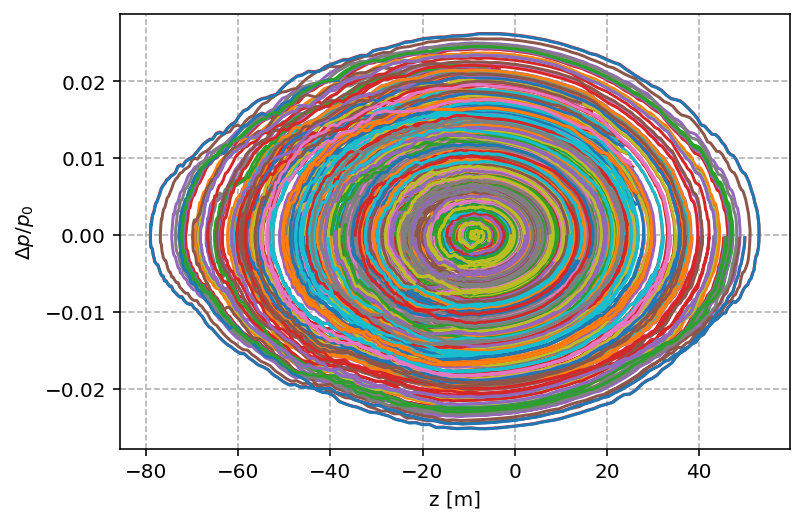

In [16]:
for ii in range(n_part):
    plt.plot([my_list_zeta[i][ii] for i in range(n_turns)], 
             [my_list_delta[i][ii] for i in range(n_turns)]
            )
plt.grid(linestyle='--')
plt.xlabel('z [m]')
plt.ylabel(r'$\Delta p / p_0$')

Text(0, 0.5, 'px')

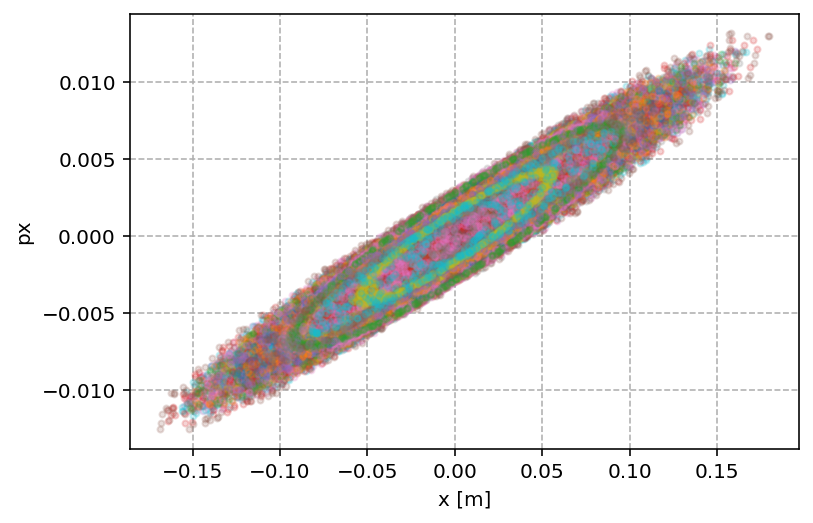

In [17]:
for ii in range(n_part):
    plt.plot([my_list_x[i][ii] for i in range(n_turns)], 
             [my_list_px[i][ii] for i in range(n_turns)],'.', alpha =.2
            )
plt.grid(linestyle='--')
plt.xlabel('x [m]')
plt.ylabel(r'px')